In [1]:
import ruptures as rpt 
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pylab as plt

### Topic 1: Simulation Study -- Data Generated using a Linear Model

(<Figure size 720x576 with 4 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

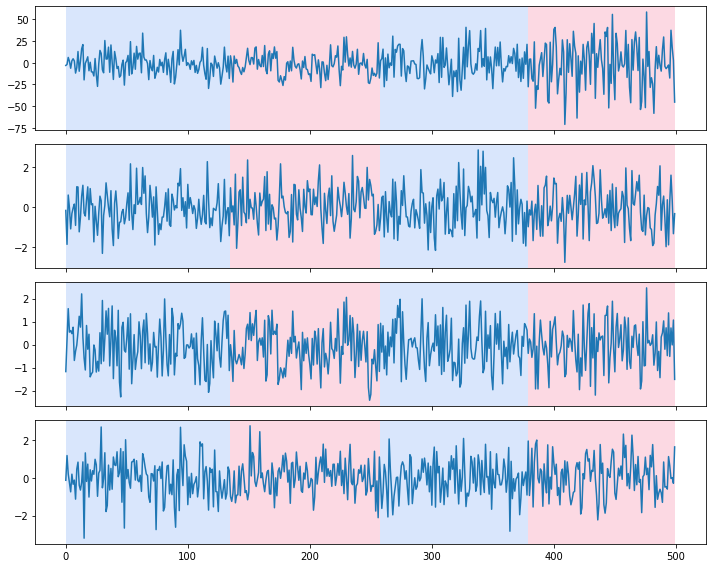

In [2]:
# Creation of data
n, dim = 500, 3  # number of samples, dimension of the covariates
n_bkps, sigma = 3, 5  # number of change points, noise standart deviation
signal, bkps = rpt.pw_linear(n, dim, n_bkps, noise_std=sigma)
rpt.display(signal, bkps)

In [3]:
type(signal)

numpy.ndarray

In [4]:
signal.shape

(500, 4)

In [5]:
# Actual location of breakpoints
bkps

[128, 254, 376, 500]

In [6]:
signal_subset = signal[:,0:2]

usr_model = "linear"
usr_algo = rpt.Pelt(model=usr_model, min_size=50).fit(signal_subset)
my_bkps = usr_algo.predict(pen=np.log(signal.shape[0])*(signal_subset.shape[1]-1))

In [7]:
my_bkps

[65, 150, 200, 250, 300, 350, 400, 450, 500]

### Topic 2: Modelling of Apple's Stock Price Data

In [4]:
# apple_series = pd.read_csv('C:/vPhrase/Projects/Analytics_Features/Change_Point_Analysis/AAPL_1999_2004_change_point.csv')
apple_series = pd.read_csv("/home/aumaron/Desktop/datasets/AAPL_1999_2004_change_point.csv")


In [5]:
apple_series.shape

(1739, 7)

(<Figure size 720x144 with 1 Axes>, [<AxesSubplot:>])

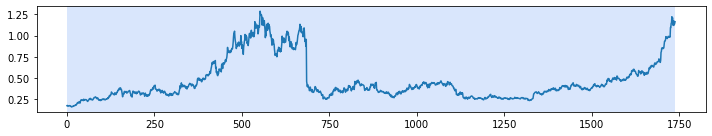

In [6]:
# Display Apple's NAV (closing price) for a 7-year period from 1998 to 2004
rpt.display(apple_series['Close'], [1739])

In [7]:
signal = apple_series['Close'].values

#### Can an AR-1 model explain the observed time series?

In [8]:
# Autocorrelation with lag-1
np.corrcoef(signal[0:1737], signal[1:1738])

array([[1.        , 0.99542192],
       [0.99542192, 1.        ]])

In [9]:
# Partial autocorrelation with 95% confidence interval
pacf(signal, nlags=10, alpha=0.05)

(array([ 1.00000000e+00,  9.93207800e-01,  7.83895867e-02, -4.24288786e-02,
         2.85470274e-03, -6.29921139e-02,  1.46128643e-02, -2.12296016e-02,
        -3.46992235e-02, -1.84504577e-04,  2.86835771e-02]),
 array([[ 1.        ,  1.        ],
        [ 0.94620775,  1.04020785],
        [ 0.03138954,  0.12538963],
        [-0.08942893,  0.00457117],
        [-0.04414535,  0.04985475],
        [-0.10999216, -0.01599207],
        [-0.03238718,  0.06161291],
        [-0.06822965,  0.02577045],
        [-0.08169927,  0.01230082],
        [-0.04718455,  0.04681554],
        [-0.01831647,  0.07568362]]))

In [10]:
# Ljung-Box test shows that an AR(2) model fits the data
arma_mod_200 = ARIMA(signal, order=(2, 0, 0)).fit()
print(arma_mod_200.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1739
Model:                 ARIMA(2, 0, 0)   Log Likelihood                4092.247
Date:                Fri, 16 Apr 2021   AIC                          -8176.495
Time:                        09:54:08   BIC                          -8154.650
Sample:                             0   HQIC                         -8168.417
                               - 1739                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4636      0.358      1.295      0.195      -0.238       1.165
ar.L1          0.8933      0.010     86.337      0.000       0.873       0.914
ar.L2          0.1048      0.010     10.107      0.0

### Topic 3: Changepoint Analysis Algorithms for Identifying Structural Changes in Apple's Stock Price Data

In [11]:
# AR model of order 2 fits the data well
# As per this model there are no breakpoints (as expected)
ar_cost = rpt.costs.CostAR(order=2)
usr_algo = rpt.Pelt(custom_cost=ar_cost, min_size=20).fit(signal)
my_bkps = usr_algo.predict(pen=np.log(signal.shape[0])*2) # AR(p=2)
my_bkps

[1739]

In [12]:
# Constant model L1
usr_algo_l1 = rpt.Pelt(model="l1", min_size=20).fit(signal)
my_bkps_l1 = usr_algo_l1.predict(pen=np.log(signal.shape[0])*1) # One parameter - median value
my_bkps_l1

[120, 370, 455, 685, 1115, 1365, 1545, 1700, 1739]

In [13]:
# Constant model L2
usr_algo_l2 = rpt.Pelt(model="l2", min_size=20).fit(signal)
my_bkps_l2 = usr_algo_l2.predict(pen=np.log(signal.shape[0])*1) # One parameter - mean value
my_bkps_l2

[445, 685, 1665, 1739]

In [14]:
# Linear model with only beta_0 (theoretically identical to the L2 model)
linear_signal = np.column_stack((signal, np.ones(signal.shape[0])))
# linear_signal
usr_algo_linear = rpt.Pelt(model="linear", min_size=20).fit(linear_signal)
my_bkps_linear = usr_algo_linear.predict(pen=np.log(signal.shape[0])*1) # One parameter - mean value
my_bkps_linear

[445, 685, 1665, 1739]

(<Figure size 720x144 with 1 Axes>, [<AxesSubplot:>])

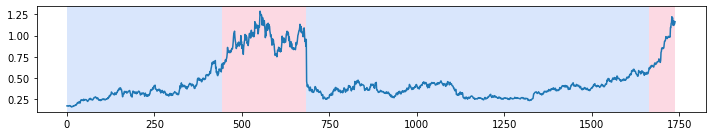

In [15]:
rpt.display(signal, my_bkps_linear)

In [16]:
# RBF model
# Non-parametric method so empirical threshold is required. Need to identify a "good" threshold
usr_algo_rbf = rpt.Pelt(model="rbf", min_size=20).fit(signal)
my_bkps_rbf = usr_algo_rbf.predict(pen=np.log(signal.shape[0])) 
my_bkps_rbf

[35,
 125,
 320,
 370,
 410,
 455,
 475,
 520,
 585,
 660,
 685,
 805,
 885,
 975,
 1110,
 1335,
 1385,
 1540,
 1605,
 1665,
 1700,
 1739]

(<Figure size 720x144 with 1 Axes>, [<AxesSubplot:>])

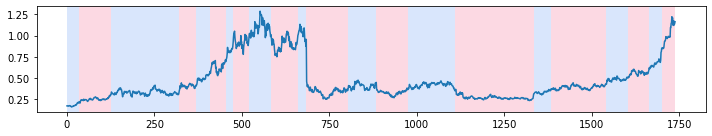

In [17]:
rpt.display(signal, my_bkps_rbf)